In [25]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

<span class="ecb">Comments by ECB</span>

# ATMO 5331 - Homework 2 - Fall 2023
## Due 24 Sep, 2023 (Sunday, 11:59 pm)

When doing this homework, remember that you have three jobs:
1. Make it work and get the right answer.
2. Clean it up so that I can understand what you've done. If you think I might not undersand, document it with a comment or a function docstring.
3. Practice _generalizing_ your thinking: write code that is tolerant of changes to the specifics of a problem, but not the structure of the problem.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring there is an even contribution by your partner.

**Question 1**

Grab the [WGS84 implementation manual](https://www.icao.int/safety/pbn/documentation/eurocontrol/eurocontrol%20wgs%2084%20implementation%20manual.pdf), and implement a translation from geodetic latitude, longitude, and altitude (referenced to the WGS84 ellisoid) to the local XYZ cartesian system used for WGS84.

Use part 1 of Helmert's formula on p. 81 (Appendix E), and refer to Fig. B-6 in Appendix B (p. 70) for information about the coordinate system notation.

Careful with degrees and radians.

Compare your results to what you get when using the `proj4` library. This library has its origins in public domain code written by the USGS, and is used in many open source packages, including the QGIS system. For easy use of the `proj4` library, we will use the helper routines in `coords.py`. I use these same helpers all the time in practice, and this code is running in operations in NOAA.

You set up a coordinate system transform object as shown below. It defaults to a WGS84 ellipsoid, so we don't have to specify that. Once the coordinate system object `geo` has been created, you can reuse it withouth calling `GeographicSystem()` again. It accepts arrays of data.
```
from coords import GeographicSystem 
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon, lat, alt) # Use degrees
```

For your dataset, please use: 
```
import numpy as np
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)
```

Demonstrate that your ECEF conversion equals that provided by the coordinate system library.


In [26]:
import numpy as np
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)
phi = np.radians(lat)
lamb = np.radians(lon)
a = 6378137
f = (1/298.257223563)
h = 0
esquared = f*(2-f)

In [27]:
v = a/np.sqrt((1-(esquared*np.sin(phi) ** 2)))
X = (v+h)*np.cos(phi)*np.cos(lamb)
Y = (v+h)*np.cos(phi)*np.sin(lamb)
Z = (v*(1-esquared)+h)*np.sin(phi)

from coords import GeographicSystem 
geo = GeographicSystem() 
X2, Y2, Z2 = geo.toECEF(lon, lat, alt) # Use degrees

print(X)
print(X2)
print(Y)
print(Y2)
print(Z)
print(Z2)

[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344]
[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344]
[-5217187.30723133 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357756 -6067823.20357756]
[-5217187.30723133 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357756 -6067823.20357756]
[ 3500334.28802236   110568.77482457        0.                0.
        0.          1100248.54773536 -1100248.54773536]
[ 3500334.28802236   110568.77482457        0.                0.
        0.          1100248.54773536 -1100248.54773536]


**Question 2.**

Using the `TangentPlaneCartesianSystem` class, convert the geodetic coordinates to local $(x, y, z)$. Create three tangent planes:

- A tangent plane centered at the MCOM building on the TTU campus, at the height of the ground at that location.

- A tangent plane centered at the MCOM building on the TTU campus, at the ellipsoid.

- A tangent plane directly below the GOES-East satellite at -75.0 degrees longitude.

Use `TangentPlaneCartesianSystem?` in the notebook to learn about the arguments accepted by the projection class. It has the same `.toECEF` and `.fromECEF` methods as the `GeographicSystem`.

Transform the geodetic dataset from the first problem into coordiantes with respect to each tangent plane.

You do not need to use the NAD83 locations of MCOM. They are only there to show my work on how I obtained the vertical position of MCOM in WGS84.

**a.** Using only the GOES-East tangent plane and the transformed geodetic dataset, show that the WGS84 earth shape is not spherical.

**b.** What is a rough, easily memorable rule of thumb for the number of kilometers per degree latitude?

**c.** Print out the tangent plane $(x,y,z)$ of the zeroth data point (it is a bit east of Lubbock). Explain why the differences in the coordinates of the two MCOM tangent planes make sense.

**d.** Imagine that there was no terrain, so that a radar located at MCOM was precisely on the WGS84 ellipsoid. If that radar were to scan toward the zeroth position at 0° elevation angle (assume no atmospheric refraction), how high above the ground would the beam be? Is this disance measured perpendicular to the ellipsoid or perpendicular to the tangent plane?

**e.** Transform your coordiantes back to ECEF from each tangent plane and show they're equal.

In [28]:
from coords import TangentPlaneCartesianSystem

# From USGS Elevation point query service
# https://nationalmap.gov/epqs/
# NAD83 lon, lat and NAVD88 vertical
mcom_lat_nad83, mcom_lon_nad83 = 33.581857, -101.880360 # NAD83
mcom_alt_nad83 = 983.15

# Using https://vdatum.noaa.gov/vdatumweb/, convert the above to "WGS84 G1674 (Use ITRF2008)"
mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179

GroundPlane = TangentPlaneCartesianSystem(mcom_lat,mcom_lon,mcom_alt)
EllipsePlane = TangentPlaneCartesianSystem(mcom_lat,mcom_lon,0)
GOESPlane = TangentPlaneCartesianSystem(ctrLon = -75)

GroundPlaneX, GroundPlaneY, GroundPlaneZ =  GroundPlane.fromECEF(X,Y,Z)
EllipsePlaneX, EllipsePlaneY, EllipsePlaneZ =  EllipsePlane.fromECEF(X,Y,Z)
GOESPlaneX, GOESPlaneY, GOESPlaneZ =  GOESPlane.fromECEF(X,Y,Z)

GroundPlaneXZero, GroundPlaneYZero, GroundPlaneZZero =  GroundPlane.fromECEF(X[0],Y[0],Z[0])
EllipsePlaneXZero, EllipsePlaneYZero, EllipsePlaneZZero =  EllipsePlane.fromECEF(X[0],Y[0],Z[0])
GOESPlaneXZero, GOESPlaneYZero, GOESPlaneZZero =  GOESPlane.fromECEF(X[0],Y[0],Z[0])

isSphere = GOESPlaneZ[2]-GOESPlaneZ[5]
if (isSphere == 0):
    print('it is a sphere!')
else:
    print(isSphere)
    print('This number should be equal to zero if the earth was a perfect sphere, but instead we find the departure from a perfect sphere')
# The altitude difference is about the height of the geoid at this location.

-634.0622291808249
This number should be equal to zero if the earth was a perfect sphere, but instead we find the departure from a perfect sphere


In [29]:
'The easiest way to remember the distance between latitude in kilometers is that the distances stays around 111.1 km'

'The easiest way to remember the distance between latitude in kilometers is that the distances stays around 111.1 km'

In [30]:
print(GroundPlaneXZero, GroundPlaneYZero, GroundPlaneZZero)
print(EllipsePlaneXZero, EllipsePlaneYZero, EllipsePlaneZZero)
print(GOESPlaneXZero, GOESPlaneYZero, GOESPlaneZZero)

print('The reason the two MCOM planes are not equal is because the ellipsoid is not on the ground. It is an ellipsoid fit to the Earth but not perfect.')

35344.860726470084 -9014.720964741062 -1061.4067358279644
35344.860726470055 -9014.720964740547 -104.22773582876198
-2375588.201968728 3500334.2879920797 -1613444.192339424
The reason the two MCOM planes are not equal is because the ellipsoid is not on the ground. It is an ellipsoid fit to the Earth but not perfect.


In [31]:
print(EllipsePlaneZZero)
print('The beam would be 104m off the ground. This distance is perpendicular to the tangent plane, not the ellipsoid')

-104.22773582876198
The beam would be 104m off the ground. This distance is perpendicular to the tangent plane, not the ellipsoid


In [32]:
GroundPlaneXECEF, GroundPlaneYECEF, GroundPlaneZECEF = GroundPlane.toECEF(GroundPlaneX, GroundPlaneY, GroundPlaneZ)
EllipsePlaneXECEF, EllipsePlaneYECEF, EllipsePlaneZECEF = EllipsePlane.toECEF(EllipsePlaneX, EllipsePlaneY, EllipsePlaneZ)
GOESPlaneXECEF, GOESPlaneYECEF, GOESPlaneZECEF = GOESPlane.toECEF(GOESPlaneX, GOESPlaneY, GOESPlaneZ)
print(GroundPlaneXECEF, GroundPlaneYECEF, GroundPlaneZECEF)
print(EllipsePlaneXECEF, EllipsePlaneYECEF, EllipsePlaneZECEF)
print(GOESPlaneXECEF, GOESPlaneYECEF, GOESPlaneZECEF)

[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] [-5217187.30723133 -6159875.21117538 -6353866.26310278 -5780555.22988657
 -6160807.25190987 -6067823.20357756 -6067823.20357756] [ 3.50033429e+06  1.10568775e+05 -9.77888703e-09 -1.07102096e-08
 -9.77888703e-09  1.10024855e+06 -1.10024855e+06]
[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] [-5217187.30723133 -6159875.21117538 -6353866.26310279 -5780555.22988657
 -6160807.25190987 -6067823.20357756 -6067823.20357756] [ 3.50033429e+06  1.10568775e+05 -8.84756446e-09 -9.77888703e-09
 -9.31322575e-09  1.10024855e+06 -1.10024855e+06]
[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721343] [-5217187.30723134 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357757 -6067823.203577

**Question 3** Use the `GeostationaryFixedGridSystem` to define two more coordiante transformations for the GOES-East and GOES-West locations at -75.0 and -135.0 degrees longitude.

Use `GeostationaryFixedGridSystem?` in the notebook to learn about the arguments accepted by the projection class.

Convert the dataset to fixed grid coordinates.

For more on fixed grid coordiantes, you can read the [GOES-R L1b product users' guide](https://www.goes-r.gov/resources/docs.html) and [my own description of GOES fixed grid coordiantes](https://github.com/deeplycloudy/glmtools/blob/master/docs/fixedgridguide.md), a.k.a. [the geostationary projection](https://proj.org/operations/projections/geos.html).



In [33]:
from coords import GeostationaryFixedGridSystem
GOESE = GeostationaryFixedGridSystem(subsat_lon=-75)
GOESW = GeostationaryFixedGridSystem(subsat_lon=-135)
GOESEX, GOESEY, GOESEZ = GOESE.fromECEF(X,Y,Z)
GOESWX, GOESWY, GOESWZ = GOESW.fromECEF(X,Y,Z)



**Question 4.** Make a plot of the east and north coordinate data from the lon/lat, 3 tangent plane, and two GOES fixed grid projections, for a total of 6 plots.

Transform and plot three more locations (your hometown, your undergraduate institution's location, and the farthest you've been from home).

Does everything make sense? If not, what do you observe? Offer a plausible explanation for what might have happened.

Label the coordinates with the altitude of the point in that coordinate reference system.

<IPython.core.display.Javascript object>


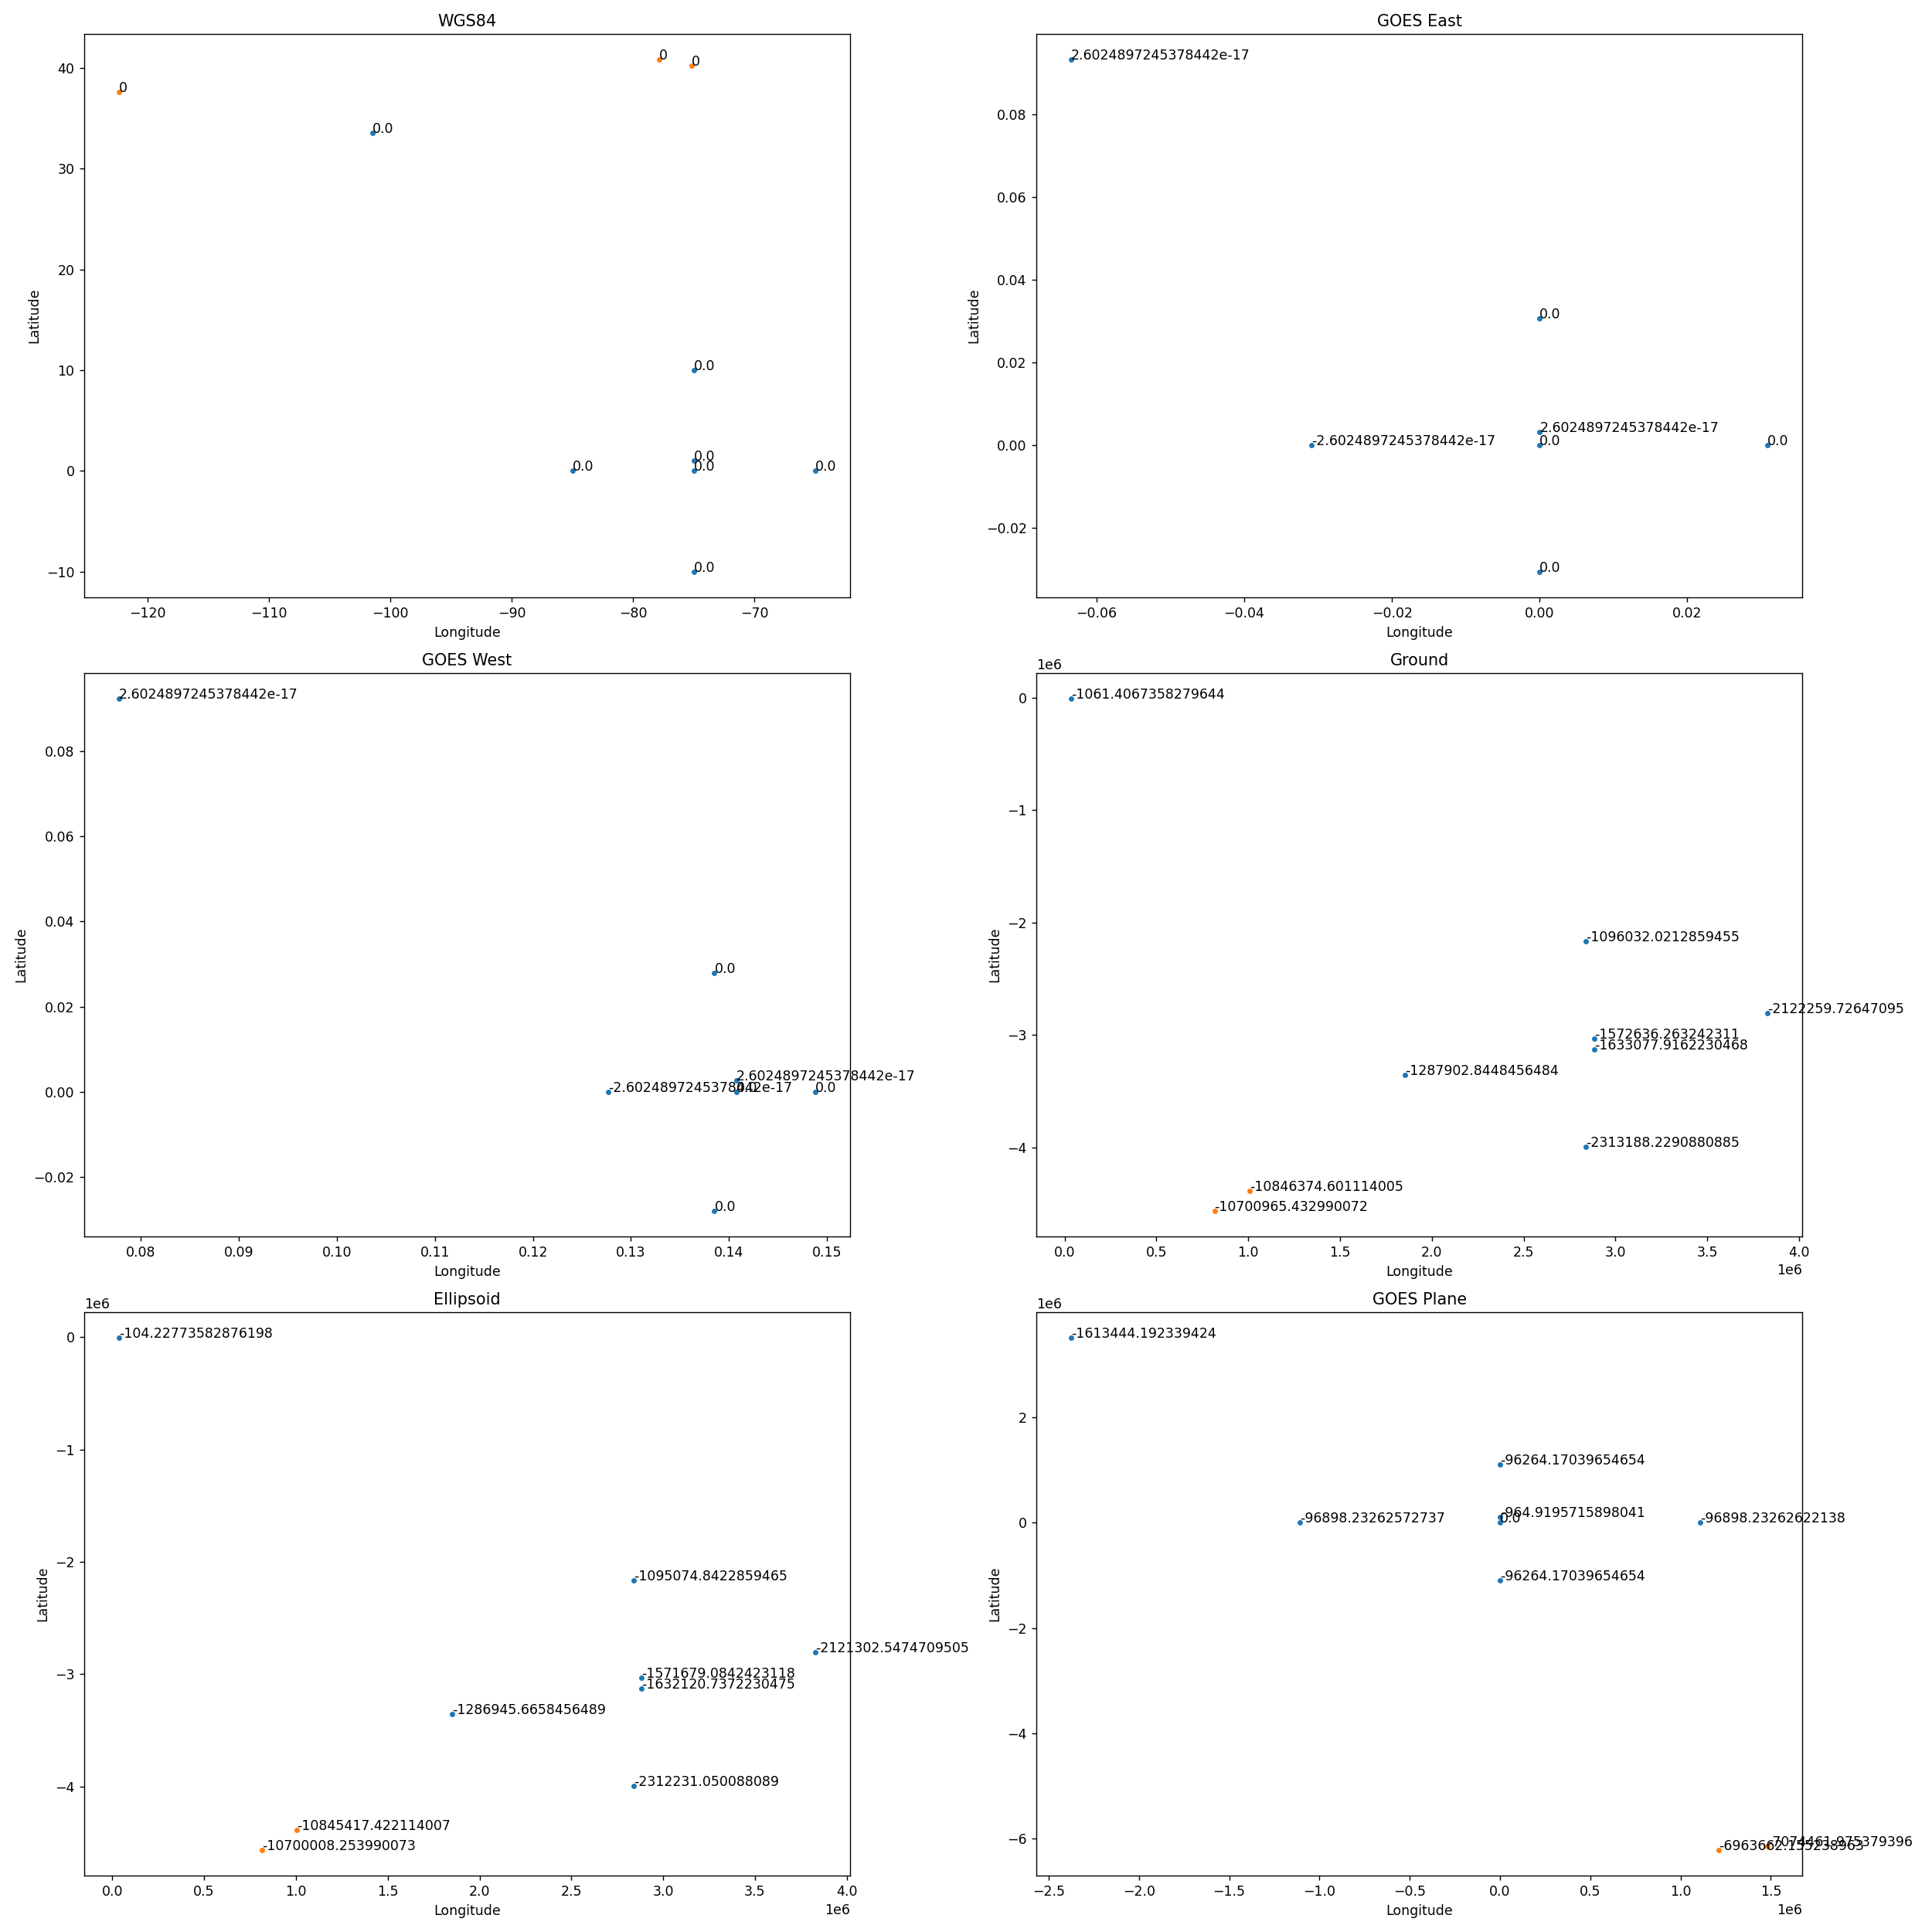

Not everything looks right in the plots. In the ground plot the points are tilted slightly and not in a perfect perpendicular line, The GOES plane puts the points in a very different spot relative to the other plots, and GOES East seems to stretch them out, while GOES West squeezes them together.
[inf inf inf]


In [41]:
loc_lon = [-75.174665968,-77.86,-122.389977]
loc_lat = [40.171832646,40.79339,37.615223]
loc_alt = [0,0,0]
#convert this to other positions

newlat,newlon,newalt = geo.toECEF(loc_lat,loc_lon,loc_alt)
GOESEast = GeostationaryFixedGridSystem(subsat_lon=-75)
GOESWest = GeostationaryFixedGridSystem(subsat_lon=-135)
GOESEastX, GOESEastY, GOESEastZ = GOESEast.fromECEF(newlat,newlon,newalt)
GOESWestX, GOESWestY, GOESWestZ = GOESWest.fromECEF(newlat,newlon,newalt)





GroundPlaneXnew, GroundPlaneYnew, GroundPlaneZnew =  GroundPlane.fromECEF(newlat,newlon,newalt)
EllipsePlaneXnew, EllipsePlaneYnew, EllipsePlaneZnew =  EllipsePlane.fromECEF(newlat,newlon,newalt)
GOESPlaneXnew, GOESPlaneYnew, GOESPlaneZnew =  GOESPlane.fromECEF(newlat,newlon,newalt)


%matplotlib notebook
import matplotlib.pyplot as plt
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

axes[0,0].plot
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_title('WGS84')
axes[0,0].plot(lon, lat, marker='.', linestyle='none')
axes[0,0].plot(loc_lon, loc_lat, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[0,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(loc_lon, loc_lat, loc_alt):
    axes[0,0].text(tlon, tlat, tlabel)

axes[0,1].plot
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')
axes[0,1].set_title('GOES East')
axes[0,1].plot(GOESEX, GOESEY, marker='.', linestyle='none')
axes[0,1].plot(GOESEastX, GOESEastY, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(GOESEX, GOESEY, GOESEZ):
    axes[0,1].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(GOESEastX, GOESEastY, GOESEastZ):
    axes[0,1].text(tlon, tlat, tlabel)
    
axes[1,0].plot
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].set_title('GOES West')
axes[1,0].plot(GOESWX, GOESWY, marker='.', linestyle='none')
axes[1,0].plot(GOESWestX, GOESWestY, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(GOESWX, GOESWY, GOESWZ):
    axes[1,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(GOESWestX, GOESWestY, GOESWestZ):
    axes[1,0].text(tlon, tlat, tlabel)
    
axes[1,1].plot
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')
axes[1,1].set_title('Ground')
axes[1,1].plot(GroundPlaneX, GroundPlaneY, marker='.', linestyle='none')
axes[1,1].plot(GroundPlaneXnew, GroundPlaneYnew, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(GroundPlaneX, GroundPlaneY, GroundPlaneZ):
    axes[1,1].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(GroundPlaneXnew, GroundPlaneYnew, GroundPlaneZnew):
    axes[1,1].text(tlon, tlat, tlabel)
    
axes[2,0].plot
axes[2,0].set_xlabel('Longitude')
axes[2,0].set_ylabel('Latitude')
axes[2,0].set_title('Ellipsoid')
axes[2,0].plot(EllipsePlaneX, EllipsePlaneY, marker='.', linestyle='none')
axes[2,0].plot(EllipsePlaneXnew, EllipsePlaneYnew, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(EllipsePlaneX, EllipsePlaneY, EllipsePlaneZ):
    axes[2,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(EllipsePlaneXnew, EllipsePlaneYnew, EllipsePlaneZnew):
    axes[2,0].text(tlon, tlat, tlabel)
    
axes[2,1].plot
axes[2,1].set_xlabel('Longitude')
axes[2,1].set_ylabel('Latitude')
axes[2,1].set_title('GOES Plane')
axes[2,1].plot(GOESPlaneX, GOESPlaneY, marker='.', linestyle='none')
axes[2,1].plot(GOESPlaneXnew, GOESPlaneYnew, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(GOESPlaneX, GOESPlaneY, GOESPlaneZ):
    axes[2,1].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(GOESPlaneXnew, GOESPlaneYnew, GOESPlaneZnew):
    axes[2,1].text(tlon, tlat, tlabel)

# Make the other five panels here
    
print('Not everything looks right in the plots. In the ground plot the points are tilted slightly and not in a perfect perpendicular line, The GOES plane puts the points in a very different spot relative to the other plots, and GOES East seems to stretch them out, while GOES West squeezes them together. Additionally, my chosen points do not appear on two of the GOES plots, but I believe this is because it is off the plane. For GOES East and West the reason they are squeezing and stretching is because of their relative points on the projection. The reason for the ellipsoid and ground projections being tilted is because of the curvature of the Earth, I believe.')

print(GOESEastX)
fig.tight_layout()

<IPython.core.display.Javascript object>


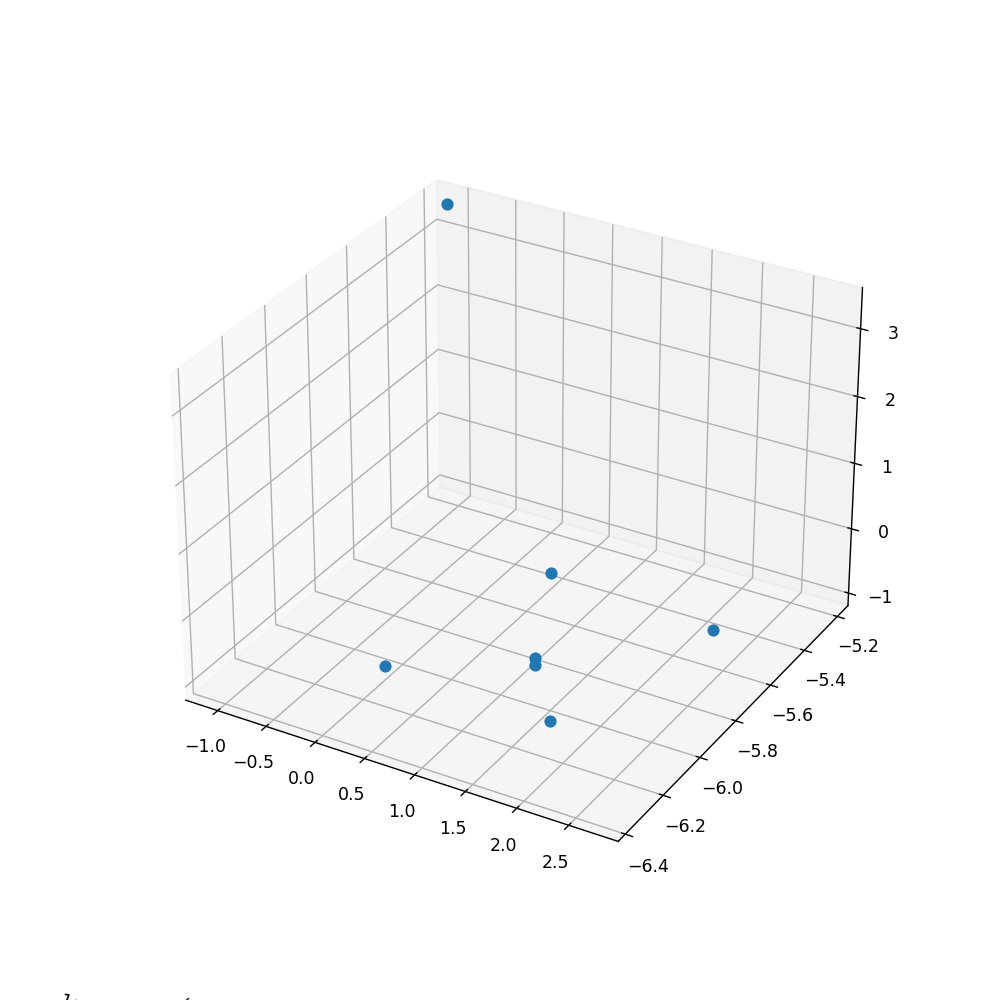

NameError: name 'locX' is not defined

In [35]:
# BONUS! Make a 3D plot of all locations. 
# Try to imagine the curved earth surface on which they reside.
# This part is not graded, but might be useful to you.

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X, Y, Z, marker='o', linestyle='none') # original locations
ax.plot(locX, locY, locZ, marker='o', linestyle='none') # personal locations
ax.set_xlabel('ECEF X (m)')
ax.set_ylabel('ECEF Y (m)')
ax.set_zlabel('ECEF Z (m)')
# ax.set_aspect('equal')

**5.** Using the arrays you created in the previous assignment, create a `pcolormesh` plot of the data in geostationary coordinates from both the GOES East and GOES West positions. (15 pts.)

[[-0.10290087 -0.09336433 -0.08285127 -0.07144871 -0.05926114 -0.04640952
  -0.03302944]
 [-0.09817789 -0.08903873 -0.07897994 -0.06808494 -0.05645315 -0.04419892
  -0.03144992]
 [-0.09267966 -0.08400829 -0.07448207 -0.06418012 -0.05319589 -0.04163619
  -0.02961963]
 [-0.08647008 -0.0783337  -0.06941372 -0.05978427 -0.04953208 -0.03875556
  -0.02756338]
 [-0.07962002 -0.07208191 -0.06383645 -0.05495214 -0.04550833 -0.0355943
  -0.02530808]]


<IPython.core.display.Javascript object>


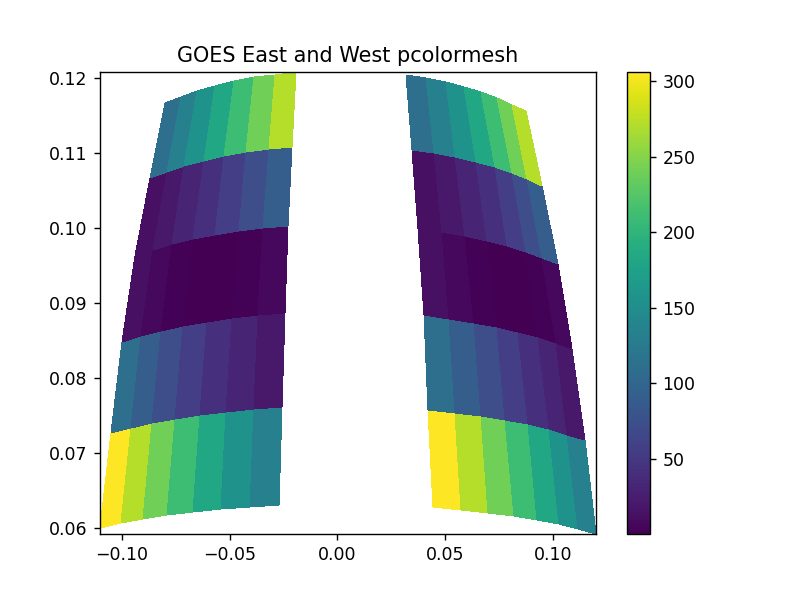

In [57]:

#FROM PREVIOUS ASSIGNMENT#
import numpy as np

mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
nlon = 7
nlat = 5
dlon, dlat = 5.0, 5.0

d = (np.arange(nlon*nlat) - (nlon*nlat/2.0))**2.0
d.shape = (nlat, nlon)

lon = (mcom_lon-(dlon*(nlon-1)*0.5)) + (np.arange(nlon)*dlon)
lat = (mcom_lat-(dlon*(nlat-1)*0.5)) + (np.arange(nlat)*dlon)

lon_2d, lat_2d = np.meshgrid(lon,lat)
alt_2d = np.zeros_like(lon_2d)



X, Y, Z = geo.toECEF(lon_2d,lat_2d,alt_2d)

previousLatEast, previousLonEast, previousAltEast = GOESE.fromECEF(X,Y,Z)
previousLatWest, previousLonWest, previousAltWest = GOESW.fromECEF(X,Y,Z)
print(previousLatEast)
plt.figure()
plt.pcolormesh(previousLatEast, previousLonEast, d)
plt.pcolormesh(previousLatWest, previousLonWest, d)
plt.title('GOES East and West pcolormesh')
plt.colorbar()

**6.** One thing we didn't do in the previous assignment was plot in a "traditional" map projection. We'll do that now with the Azimuthal Equidistant and Gnomonic projections, centered on MCOM, as defined below. The MapProjection class has the same to/from ECEF methods, and coordinates returned are in meters relative to the center point. (15 pts.)

If you're curious, you can peruse [the full list of projections](https://proj.org/operations/projections/index.html) to see how to define others.

Create a plot of the same data in each map projection, and set the axis limits to +/- 1600 km. Do you notice any differences in the two projections?

<IPython.core.display.Javascript object>


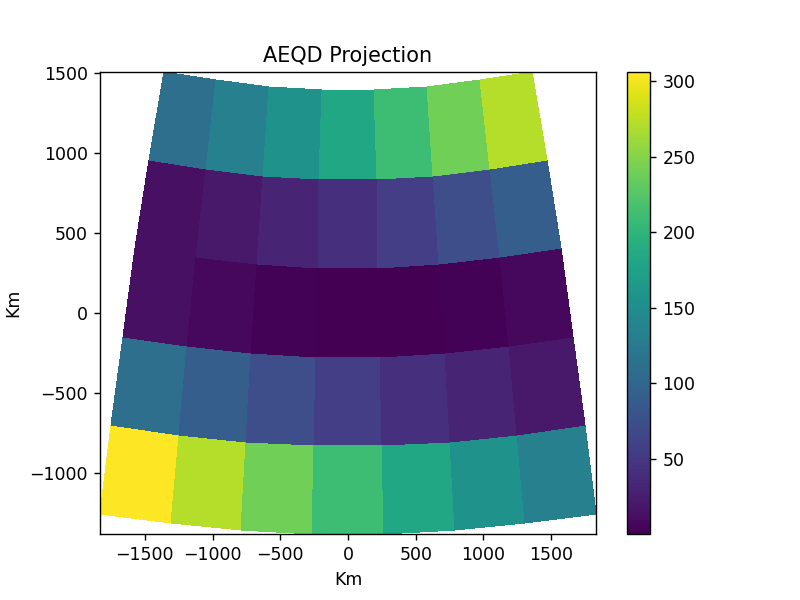

C:\Users\kylew\AppData\Local\Temp\ipykernel_7232\1620427772.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(MapAEQDX, MapAEQDY, d, shading='nearest')


<IPython.core.display.Javascript object>


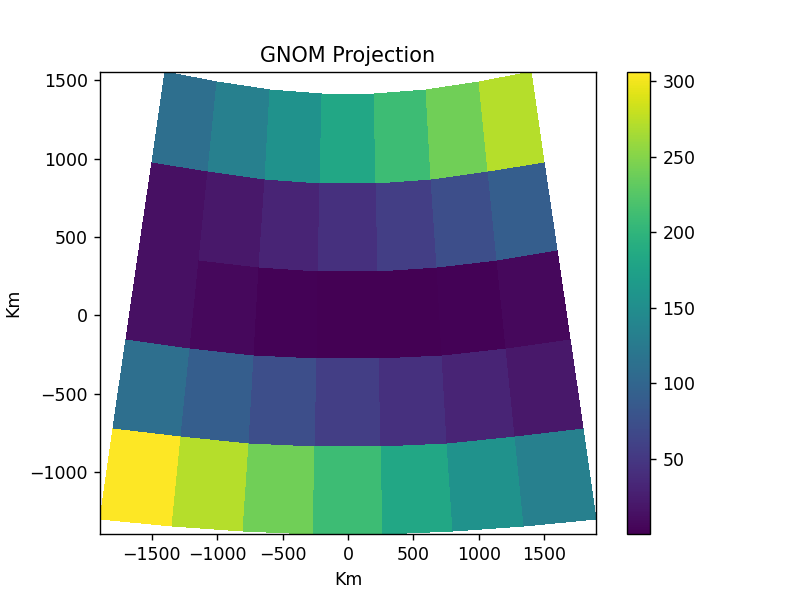

At first glance, I really didnt notice any difference between the two plots. After discussing with some fellow students I guess there might be a very slight horizontal stretch, but very minor


C:\Users\kylew\AppData\Local\Temp\ipykernel_7232\1620427772.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(MapGNOMX, MapGNOMY, d, shading='nearest')


In [59]:
from coords import MapProjection 
aeqd = MapProjection(projection='aeqd', lon_0=mcom_lon, lat_0=mcom_lat)
gnom = MapProjection(projection='gnom', lon_0=mcom_lon, lat_0=mcom_lat)

MapAEQDX, MapAEQDY, MapAEQDZ = aeqd.fromECEF(X,Y,Z)
MapGNOMX, MapGNOMY, MapGNOMZ = gnom.fromECEF(X,Y,Z)

MapAEQDX /= 1000
MapAEQDY /= 1000
MapAEQDZ /= 1000
MapGNOMX /= 1000
MapGNOMY /= 1000
MapGNOMZ /= 1000

plt.figure()
plt.pcolormesh(MapAEQDX, MapAEQDY, d, shading='nearest')
plt.title('AEQD Projection')
plt.xlabel('Km')
plt.ylabel('Km')
plt.colorbar()

plt.figure()
plt.pcolormesh(MapGNOMX, MapGNOMY, d, shading='nearest')
plt.title('GNOM Projection')
plt.xlabel('Km')
plt.ylabel('Km')
plt.colorbar()

print('At first glance, I really didnt notice any difference between the two plots. After discussing with some fellow students I guess there might be a very slight horizontal stretch, but very minor')